# Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Built-in libraries
#
import time
import numpy    as np
import pandas   as pd
from   tqdm     import tqdm



# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization libraries
#
import matplotlib.pyplot as plt


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.linear_model    import *
from sklearn.model_selection import train_test_split, GridSearchCV


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Linear Trees library
#
from lineartree import LinearTreeRegressor


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# User library
#
from utils.PerformanceMetrics     import *

# Import data

In [3]:
# Start timer
#
start = time.time()


# Load dataset
#
df = pd.read_csv('Data/Temperature.csv')
print('[INFO] Dataset loaded')


# Stop timer
#
print('[INFO] Time %.2f' % (time.time() - start))


df.head()

[INFO] Dataset loaded
[INFO] Time 0.01


,Date,Temperature
0,2015-02-11 14:48:00,21.7600
1,2015-02-11 14:49:00,21.7900
2,2015-02-11 14:50:00,21.7675
3,2015-02-11 14:51:00,21.7675
4,2015-02-11 14:52:00,21.7900


## Preprocess

### Set index

In [4]:
df['Date'] = df['Date'].astype('datetime64')
df.set_index('Date', inplace=True)

### Create features based on data

In [5]:
df['Hour']       = df.index.hour
df['Minute']     = df.index.minute
df['Wday']       = df.index.dayofweek  # or dt.weekday
df['Month']      = df.index.month
df['is_weekend'] = np.where(df.index.weekday.isin([5,6]), 1, 0)

df.head(4)

,Temperature,Hour,Minute,Wday,Month,is_weekend
Date,,,,,,
2015-02-11 14:48:00,21.7600,14,48,2,2,0
2015-02-11 14:49:00,21.7900,14,49,2,2,0
2015-02-11 14:50:00,21.7675,14,50,2,2,0
2015-02-11 14:51:00,21.7675,14,51,2,2,0


# Training/Testing

In [6]:
idx = int(df.shape[0] * 0.7)

df_train = df[:idx]
df_test  = df[idx:]

## Visualization

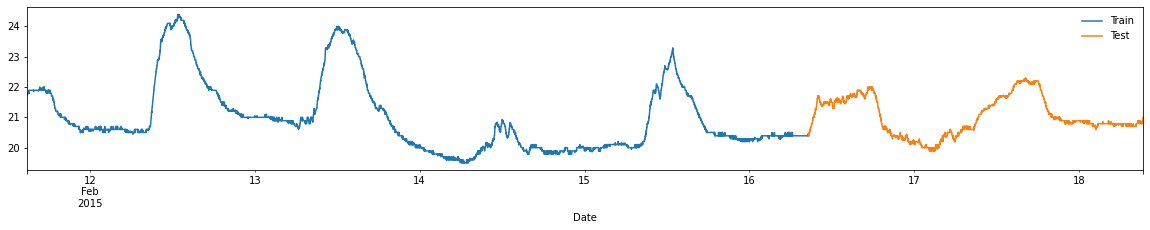

In [7]:
plt.figure( figsize=(20, 3));

df_train['Temperature'].plot(color='tab:blue');
df_test['Temperature'].plot(color='tab:orange');

plt.legend(['Train', 'Test'], frameon=False);

## Create Training/Testing datasets

In [8]:
# Parameters
#
Lag    = 5
Target = 'Temperature'

# Utility functions
#
def CreateDataset(df, Lag = 10, Target='Temperature'):
    
    # Re-arrange columns 
    #
    columnsX = [col for col in df.columns if col != Target]
    
    
    X, Y = [], []
    for i in tqdm( range( df.shape[0]-Lag ) ):
        
        Instance  = df[Target][i:i+Lag].tolist()
        Instance += df.iloc[i][ columnsX ].tolist()

        X += [ Instance ]
        Y += [ df[ Target][i] ]

    return (np.asarray(X), np.asarray(Y))

In [9]:
trainX, trainY =  CreateDataset(df_train, Lag, Target)
testX,  testY  =  CreateDataset(df_test, Lag,  Target)


Features = ['Lag-{}'.format(i) for i in range(Lag,0,-1)] + [col for col in df.columns if col != Target]


print('[INFO] Training data: ', trainX.shape)
print('[INFO] Testing data:  ', testX.shape)

100%|██████████| 2921/2921 [00:02<00:00, 1348.02it/s]

[INFO] Training data:  (6821, 10)
[INFO] Testing data:   (2921, 10)


# Linear Tree model

## Hyperparameter optimization process

In [10]:
%%time

param_grid = {'max_depth': [1, 2, 3], 'min_samples_split': [0.4, 0.3, 0.2]}
scoring    = 'neg_mean_squared_error' # 'r2'
cv         = 10

grid_search = GridSearchCV(estimator  = LinearTreeRegressor( Ridge() ), 
                           param_grid = param_grid, 
                           scoring    = scoring, 
                           n_jobs     = -1, 
                           cv         = cv,
                           refit      = True)

model = grid_search.fit(trainX, trainY)

CPU times: user 966 ms, sys: 533 ms, total: 1.5 s
Wall time: 3.46 s


## Optimized hyperparameters

In [11]:
print('[INFO] Optimized hyperparameters\n')

for (parameter, value) in kgs.best_params_.items():
    if ( isinstance(value, float) ):
        print(' >%25s: %.3f' % (parameter, value))
    else:
        print(' >%25s: %s'   % (parameter, value))

[INFO] Optimized hyperparameters

 >                max_depth: 1
 >        min_samples_split: 0.400


In [12]:
# Plot model decision path
#
# model.best_estimator_.plot_model(feature_names = Features)

## Evaluation

In [13]:
pred = model.predict(testX)

print( "> RMSE:  ", rmse(testY, pred))
print( "> MAE:   ", mae(testY, pred) )
print( "> MAPE:  ", mape(testY, pred) )
print( "> SMAPE: ", smape(testY, pred) )
print( "> R2:    ", R2(testY, pred) )


> RMSE:   0.00371432168826493
> MAE:    0.0023756235417443845
> MAPE:   0.011325536538396554
> SMAPE:  0.01132543661408053
> R2:     0.9999638973938443


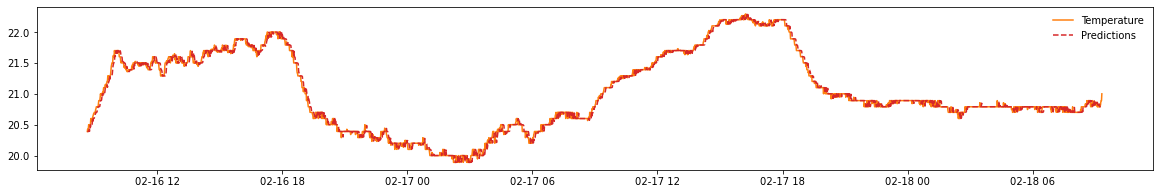

In [14]:
plt.figure( figsize=(20, 3));


plt.plot(df_test.index[Lag:], df_test[ Target ][Lag:], color='tab:orange')
plt.plot(df_test.index[Lag:], pred, linestyle='--', color='tab:red')

plt.legend(['Temperature', 'Predictions'], frameon=False);